In [6]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 

import os

import cv2

from skimage import io

ROOT_DIR = os.getcwd()
CHECKERBOARD_PATH = os.path.join(ROOT_DIR, 'Images', 'checkerboards')

## Create a checkerboard pattern

* Must have an even image size (odd sizes will be truncated down)
* Shape must be of length 1 or greater in both dimensions

* OpenCV needs a white border to recognise the checkerboard for calibration, the default is set to 
16 pixels thickness

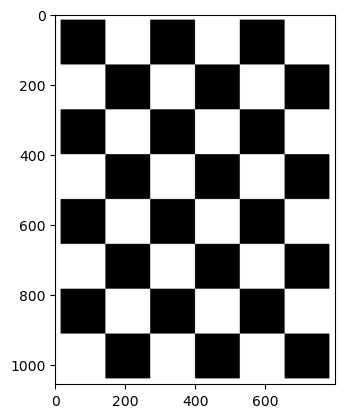

: 

In [48]:
def checkerboard(width, shape=(8, 8), pad=16):
    board = np.indices(shape).sum(axis=0) % 2
    img_unpadded = np.repeat(np.repeat(board, int(width / max(shape)), axis=1), int(width / max(shape)), axis=0)

    height, width = img_unpadded.shape
    new_height = height + 2 * pad
    new_width = width + 2 * pad

    return np.pad(img_unpadded, pad_width=pad, mode='constant', constant_values=1)

shape = (8, 6)
width = 1024

cb = checkerboard(width, shape)
plt.imshow(cb, cmap='gray')

# Save the generated pattern

name = os.path.join(CHECKERBOARD_PATH, f'{shape[0]}x{shape[1]}_{width}.jpg')
plt.imsave(name, cb, cmap='gray')

## Use the checkerboard images to calculate a camera property matrix

In [20]:
imgs_path = os.path.join(CHECKERBOARD_PATH, 'renders')

imgs = []
i = 0
while True:
    img = cv2.imread(os.path.join(imgs_path, f'render_{i}.jpg'))
    
    if img is None: break

    imgs.append(img)
    i += 1
    
IMGS_REQUIRED = 10

if len(imgs) < IMGS_REQUIRED:
    print("Not enough images passed for calibration")
    raise
else:
    print(f'{len(imgs)} checkerboard renders successfully loaded')



10 checkerboard renders successfully loaded


In [23]:
import cv2

CHECKERBOARD = (7, 5)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

threedpoints = []
twodpoints = []

objectp3d = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

for i, image in enumerate(imgs):
    #image = np.array(256 - image, dtype=np.uint8)
    grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(grey_img, CHECKERBOARD, 
                                            cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if ret:
        threedpoints.append(objectp3d)

        corners2 = cv2.cornerSubPix(grey_img, corners, (11, 11), (-1, -1), criteria)

        twodpoints.append(corners2)
        
        #image = cv2.drawChessboardCorners(image, CHECKERBOARD, corners2, ret)
    else:
        print(f'Failed to find checkerboard on image {i}')

cv2.destroyAllWindows()

h, w = image.shape[:2]

ret, cam_mat, dist_mat, r_vecs, t_vecs = cv2.calibrateCamera(threedpoints, twodpoints, grey_img.shape[::-1], None, None)

if not ret:
    raise

optimal_mat, roi = cv2.getOptimalNewCameraMatrix(cam_mat, dist_mat, (w, h), 1, (w, h))

print(f'Camera matrix: {cam_mat}')
print(f'Dist matrix: {dist_mat}')
print(f'Optimal matrix: {optimal_mat}')

Camera matrix: [[956.77151139   0.         611.64475506]
 [  0.         957.14527194 383.35436203]
 [  0.           0.           1.        ]]


In [24]:
img_test = cv2.imread(os.path.join(imgs_path, f'test.jpg'))

h, w = img_test.shape[:2]

img_fixed = cv2.undistort(img_test, cam_mat, dist_mat, None, optimal_mat)
# crop the image
#x, y, w, h = roi
#img_fixed = img_fixed[y:y+h, x:x+w]

cv2.imshow('image', img_fixed)
cv2.waitKey(0)

-1